In [ ]:
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier
import joblib
import tensorflow as tf
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

# Paths to pre-extracted features
FAKE_TRAIN_FEATURES_PATH = 'drive/MyDrive/SP_cup/features/standardized_fake_train.pkl'
REAL_TRAIN_FEATURES_PATH = 'drive/MyDrive/SP_cup/features/standardized_real_train.pkl'
OUTPUT_MODEL_PATH = 'drive/MyDrive/SP_cup/landmark_model.joblib'
RANDOM_STATE = 52

# Configure GPU for TensorFlow
gpus = tf.config.list_physical_devices('GPU')

# Function to load features from file
def load_features(file_path):
    with open(file_path, 'rb') as f:
        return pickle.load(f)

# Validate and extract valid feature vectors
def validate_and_extract(features):
    valid_features = []
    for entry in tqdm(features, desc="Validating and extracting features"):
        if isinstance(entry, list):
            valid_features.extend(
                [sub_entry['features'] for sub_entry in entry if isinstance(sub_entry, dict) and 'features' in sub_entry]
            )
        elif isinstance(entry, dict) and 'features' in entry:
            valid_features.append(entry['features'])
    return np.array(valid_features, dtype=np.float32)

# Load and process fake and real features
print("Loading features...")
fake_features = load_features(FAKE_TRAIN_FEATURES_PATH)
real_features = load_features(REAL_TRAIN_FEATURES_PATH)

# Validate and extract features
print("Validating and extracting features...")
X_fake = validate_and_extract(fake_features)
X_real = validate_and_extract(real_features)

# Create labels
y_fake = np.ones(len(X_fake))  # Fake class label (1)
y_real = np.zeros(len(X_real))  # Real class label (0)

# Combine features and labels
print("Combining features and labels...")
X_all = np.vstack((X_fake, X_real))  # Combine both features
y_all = np.hstack((y_fake, y_real))  # Combine labels for both

# Normalize features
print("Normalizing features...")
scaler = StandardScaler()
X_all = scaler.fit_transform(X_all)

# Split dataset into training and validation sets
print("Splitting dataset into training and validation sets...")
X_train, X_val, y_train, y_val = train_test_split(
    X_all, y_all, test_size=0.2, random_state=RANDOM_STATE, stratify=y_all
)

# Compute class weights
print("Computing class weights...")
class_weight_dict = {0: len(y_train) / np.sum(y_train == 0), 1: len(y_train) / np.sum(y_train == 1)}

# Train the XGBoost model
def train_model(X_train, y_train, class_weight_dict):
    print("Training XGBoost model with multithreading and GPU utilization...")
    model = XGBClassifier(
        scale_pos_weight=class_weight_dict[0] / class_weight_dict[1],
        tree_method="gpu_hist",  # Use GPU for training
        predictor="gpu_predictor",
        use_label_encoder=False,
        eval_metric="logloss",
        random_state=RANDOM_STATE,
        n_jobs=-1  # Use all available CPU threads for data preparation
    )
    model.fit(X_train, y_train, sample_weight=np.array([class_weight_dict[label] for label in y_train]))
    return model

# Train the model
model = train_model(X_train, y_train, class_weight_dict)

# Save the trained model
print("Saving trained model...")
joblib.dump(model, OUTPUT_MODEL_PATH)
print(f"Model saved to {OUTPUT_MODEL_PATH}")

# Evaluate the model
def evaluate_model(model, X_val, y_val):
    print("Evaluating the model...")
    y_pred = model.predict(X_val)
    print("Classification Report:")
    from sklearn.metrics import classification_report, accuracy_score
    print(classification_report(y_val, y_pred))
    print(f"Validation Accuracy: {accuracy_score(y_val, y_pred):.4f}")

evaluate_model(model, X_val, y_val)


Loading features...
Validating and extracting features...


Validating and extracting features: 100%|██████████| 17090/17090 [00:00<00:00, 1472849.83it/s]


Combining features and labels...
Normalizing features...
Splitting dataset into training and validation sets...
Computing class weights...
Training XGBoost model with multithreading and GPU utilization...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:09:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:09:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Saving trained model...
Model saved to drive/MyDrive/SP_cup/landmark_model.joblib
Evaluating the model...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:09:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:09:13] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      3418
         1.0       1.00      1.00      1.00     21943

    accuracy                           1.00     25361
   macro avg       1.00      1.00      1.00     25361
weighted avg       1.00      1.00      1.00     25361

Validation Accuracy: 1.0000


In [ ]:
# Step 1: Download the shape predictor file
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2

# Step 2: Extract the downloaded bz2 file
!bunzip2 shape_predictor_68_face_landmarks.dat.bz2

# Step 3: Set the correct path to the downloaded file
predictor_path = '/content/shape_predictor_68_face_landmarks.dat'

--2025-01-19 11:14:06--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  78.7MB/s    in 0.8s    

2025-01-19 11:14:07 (78.7 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]



Loading facial landmarks...
Loading spatial features...
Combining facial landmarks and spatial features...
Combined features shape: (3067, 1416)
Trimmed combined features shape: (3067, 1280)
Loading model...
Predicting on validation data...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:13:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Evaluating model...
              precision    recall  f1-score   support

           0       0.51      1.00      0.67      1544
           1       0.78      0.01      0.02      1523

    accuracy                           0.51      3067
   macro avg       0.64      0.50      0.34      3067
weighted avg       0.64      0.51      0.35      3067

Validation Accuracy: 0.5067
Confusion Matrix:
[[1540    4]
 [1509   14]]


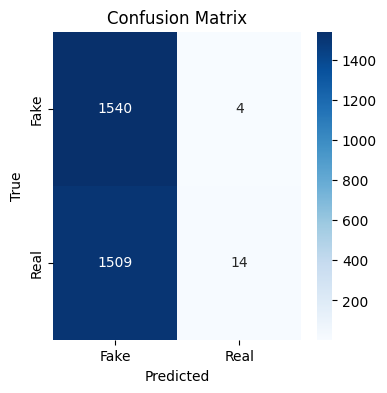

In [ ]:
import numpy as np
import pickle
import joblib
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load pre-saved data (Landmarks and Spatial Features)
print("Loading facial landmarks...")
with open('drive/MyDrive/SP_cup/fake_valid_landmarks.pkl', 'rb') as f:
    fake_valid_landmarks = pickle.load(f)

with open('drive/MyDrive/SP_cup/real_valid_landmarks.pkl', 'rb') as f:
    real_valid_landmarks = pickle.load(f)

# Labels: Fake = 0, Real = 1
fake_valid_labels = [1] * len(fake_valid_landmarks)
real_valid_labels = [0] * len(real_valid_landmarks)

# Load spatial features from pickle files
print("Loading spatial features...")
with open('drive/MyDrive/SP_cup/features/spatial_valid_fake.pkl', 'rb') as f:
    fake_spatial_features = pickle.load(f)

with open('drive/MyDrive/SP_cup/features/spatial_valid_real.pkl', 'rb') as f:
    real_spatial_features = pickle.load(f)

# Ensure spatial features match the number of images (after filtering None values)
if len(fake_spatial_features) != len(fake_valid_landmarks):
    print(f"Warning: Mismatch between number of fake images and spatial features: {len(fake_spatial_features)} vs {len(fake_valid_landmarks)}")
    fake_spatial_features = [fake_spatial_features[i] for i in range(len(fake_valid_landmarks)) if fake_valid_landmarks[i] is not None]

if len(real_spatial_features) != len(real_valid_landmarks):
    print(f"Warning: Mismatch between number of real images and spatial features: {len(real_spatial_features)} vs {len(real_valid_landmarks)}")
    real_spatial_features = [real_spatial_features[i] for i in range(len(real_valid_landmarks)) if real_valid_landmarks[i] is not None]

# Combine facial landmarks and spatial features
print("Combining facial landmarks and spatial features...")
combined_features = []

# Function to ensure landmarks and spatial features are valid arrays
def ensure_valid_array(data):
    if isinstance(data, np.ndarray):
        return data.flatten()  # Flatten the array to 1D
    else:
        return np.array(data).flatten()  # Ensure it's an array and flatten

# Combine features for fake images
for lm, spatial in zip(fake_valid_landmarks, fake_spatial_features):
    if lm is not None and spatial is not None:
        lm = ensure_valid_array(lm)
        spatial = spatial.get('features', None)  # Extract the features array from the dictionary
        if spatial is not None:
            spatial = ensure_valid_array(spatial)
            if len(lm) > 0 and len(spatial) > 0:
                combined_features.append(np.concatenate([lm, spatial]))

# Combine features for real images
for lm, spatial in zip(real_valid_landmarks, real_spatial_features):
    if lm is not None and spatial is not None:
        lm = ensure_valid_array(lm)
        spatial = spatial.get('features', None)  # Extract the features array from the dictionary
        if spatial is not None:
            spatial = ensure_valid_array(spatial)
            if len(lm) > 0 and len(spatial) > 0:
                combined_features.append(np.concatenate([lm, spatial]))

# Convert to numpy array and ensure correct data type
try:
    combined_features = np.array(combined_features, dtype=np.float32)
    print(f"Combined features shape: {combined_features.shape}")
except Exception as e:
    print(f"Error during conversion to numpy array: {e}")

# Combine labels
combined_labels = np.array(fake_valid_labels + real_valid_labels, dtype=np.int32)

# Ensure the combined features have the same number of columns as expected by the model
expected_num_features = 1280  # Number of features the model expects
if combined_features.shape[1] > expected_num_features:
    combined_features = combined_features[:, :expected_num_features]
    print(f"Trimmed combined features shape: {combined_features.shape}")
elif combined_features.shape[1] < expected_num_features:
    print(f"Warning: Combined features have fewer than {expected_num_features} features. Model might not work as expected.")

# Load model
print("Loading model...")
model = joblib.load('drive/MyDrive/SP_cup/landmark_model.joblib')

# Predict
print("Predicting on validation data...")
y_pred_proba = model.predict_proba(combined_features)[:, 1]  # Get probabilities for class 1

# Adjust threshold for prediction (example: threshold at 0.3 for higher recall)
threshold = 0.4
y_pred = (y_pred_proba > threshold).astype(int)

# Evaluate
print("Evaluating model...")
print(classification_report(combined_labels, y_pred))
print(f"Validation Accuracy: {accuracy_score(combined_labels, y_pred):.4f}")

# Confusion Matrix
cm = confusion_matrix(combined_labels, y_pred)
print("Confusion Matrix:")
print(cm)

# Plot Confusion Matrix
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
import numpy as np
import pickle
import joblib
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score

# Load pre-saved data (Landmarks and Spatial Features)
print("Loading facial landmarks...")
with open('drive/MyDrive/SP_cup/fake_valid_landmarks.pkl', 'rb') as f:
    fake_valid_landmarks = pickle.load(f)

with open('drive/MyDrive/SP_cup/real_valid_landmarks.pkl', 'rb') as f:
    real_valid_landmarks = pickle.load(f)

# Labels: Fake = 0, Real = 1
fake_valid_labels = [0] * len(fake_valid_landmarks)
real_valid_labels = [1] * len(real_valid_landmarks)

# Load spatial features from pickle files
print("Loading spatial features...")
with open('drive/MyDrive/SP_cup/features/spatial_valid_fake.pkl', 'rb') as f:
    fake_spatial_features = pickle.load(f)

with open('drive/MyDrive/SP_cup/features/spatial_valid_real.pkl', 'rb') as f:
    real_spatial_features = pickle.load(f)

# Combine facial landmarks and spatial features
print("Combining facial landmarks and spatial features...")

# Function to ensure landmarks and spatial features are valid arrays
def ensure_valid_array(data):
    if isinstance(data, np.ndarray):
        return data.flatten()  # Flatten the array to 1D
    else:
        return np.array(data).flatten()  # Ensure it's an array and flatten

combined_features = []

# Combine features for fake images
for lm, spatial in zip(fake_valid_landmarks, fake_spatial_features):
    if lm is not None and spatial is not None:
        lm = ensure_valid_array(lm)
        spatial = spatial.get('features', None)  # Extract the features array from the dictionary
        if spatial is not None:
            spatial = ensure_valid_array(spatial)
            if len(lm) > 0 and len(spatial) > 0:
                combined_features.append(np.concatenate([lm, spatial]))

# Combine features for real images
for lm, spatial in zip(real_valid_landmarks, real_spatial_features):
    if lm is not None and spatial is not None:
        lm = ensure_valid_array(lm)
        spatial = spatial.get('features', None)  # Extract the features array from the dictionary
        if spatial is not None:
            spatial = ensure_valid_array(spatial)
            if len(lm) > 0 and len(spatial) > 0:
                combined_features.append(np.concatenate([lm, spatial]))

# Convert to numpy array
combined_features = np.array(combined_features, dtype=np.float32)

# Combine labels
combined_labels = np.array(fake_valid_labels + real_valid_labels, dtype=np.int32)

# Resampling with SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(combined_features, combined_labels)

# Define the hyperparameters for XGBoost
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'booster': 'gbtree',
    'max_depth': 5,  # You can tune this
    'learning_rate': 0.1,  # You can tune this
    'n_estimators': 100,  # You can tune this
    'subsample': 0.8,  # You can tune this
    'colsample_bytree': 0.8,  # You can tune this
    'gamma': 0.1,  # You can tune this
    'random_state': 52
}

# Prepare the DMatrix for XGBoost
dtrain = xgb.DMatrix(X_resampled, label=y_resampled)

# Perform Cross-validation with hyperparameter tuning
cv_results = xgb.cv(
    params=params,
    dtrain=dtrain,
    num_boost_round=5,
    nfold=3,
    metrics=['error', 'logloss'],
    early_stopping_rounds=5,
    verbose_eval=True
)

# Print the results
print("Cross-validation results:")
print(cv_results)

# Best iteration from cross-validation (based on evaluation metrics)
best_iteration = cv_results['test-logloss-mean'].idxmin()

# Train the final model using the best parameters
final_model = xgb.train(params, dtrain, num_boost_round=best_iteration)

# Save the final model
joblib.dump(final_model, 'best_landmark_model.xgb')

# Predict using the final model
print("Predicting on validation data...")
y_pred = final_model.predict(xgb.DMatrix(X_resampled))
y_pred = np.round(y_pred)  # Round to get binary predictions (0 or 1)

# Evaluate the model
print("Evaluating model...")
print(classification_report(y_resampled, y_pred))
print(f"Validation Accuracy: {accuracy_score(y_resampled, y_pred):.4f}")


Loading facial landmarks...
Loading spatial features...
Combining facial landmarks and spatial features...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:18:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:18:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-error:0.05716+0.00577	train-logloss:0.61528+0.00180	test-error:0.09586+0.01081	test-logloss:0.62289+0.00142
[1]	train-error:0.05068+0.00692	train-logloss:0.55437+0.00187	test-error:0.08582+0.01336	test-logloss:0.56620+0.00318
[2]	train-error:0.03562+0.00166	train-logloss:0.49991+0.00255	test-error:0.06541+0.00563	test-logloss:0.51647+0.00413
[3]	train-error:0.02996+0.00256	train-logloss:0.45068+0.00240	test-error:0.05959+0.00485	test-logloss:0.47075+0.00344
[4]	train-error:0.02526+0.00458	train-logloss:0.40813+0.00138	test-error:0.05732+0.00755	test-logloss:0.43172+0.00298
Cross-validation results:
   train-error-mean  train-error-std  train-logloss-mean  train-logloss-std  \
0          0.057156         0.005769            0.615285           0.001796   
1          0.050679         0.006920            0.554375           0.001867   
2          0.035622         0.001659            0.499912           0.002547   
3          0.029955         0.002557            0.450680           0

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:18:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


Predicting on validation data...
Evaluating model...
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      1544
           1       0.96      0.98      0.97      1544

    accuracy                           0.97      3088
   macro avg       0.97      0.97      0.97      3088
weighted avg       0.97      0.97      0.97      3088

Validation Accuracy: 0.9660


In [ ]:
import numpy as np
import pickle
import joblib
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score

# Load pre-saved data (Landmarks and Spatial Features)
print("Loading facial landmarks...")
with open('drive/MyDrive/SP_cup/fake_valid_landmarks.pkl', 'rb') as f:
    fake_valid_landmarks = pickle.load(f)

with open('drive/MyDrive/SP_cup/real_valid_landmarks.pkl', 'rb') as f:
    real_valid_landmarks = pickle.load(f)

# Labels: Fake = 0, Real = 1
fake_valid_labels = [0] * len(fake_valid_landmarks)
real_valid_labels = [1] * len(real_valid_landmarks)

# Load spatial features from pickle files
print("Loading spatial features...")
with open('drive/MyDrive/SP_cup/features/spatial_valid_fake.pkl', 'rb') as f:
    fake_spatial_features = pickle.load(f)

with open('drive/MyDrive/SP_cup/features/spatial_valid_real.pkl', 'rb') as f:
    real_spatial_features = pickle.load(f)

# Combine facial landmarks and spatial features
print("Combining facial landmarks and spatial features...")

# Function to ensure landmarks and spatial features are valid arrays
def ensure_valid_array(data):
    if isinstance(data, np.ndarray):
        return data.flatten()  # Flatten the array to 1D
    else:
        return np.array(data).flatten()  # Ensure it's an array and flatten

combined_features = []

# Combine features for fake images
for lm, spatial in zip(fake_valid_landmarks, fake_spatial_features):
    if lm is not None and spatial is not None:
        lm = ensure_valid_array(lm)
        spatial = spatial.get('features', None)  # Extract the features array from the dictionary
        if spatial is not None:
            spatial = ensure_valid_array(spatial)
            if len(lm) > 0 and len(spatial) > 0:
                combined_features.append(np.concatenate([lm, spatial]))

# Combine features for real images
for lm, spatial in zip(real_valid_landmarks, real_spatial_features):
    if lm is not None and spatial is not None:
        lm = ensure_valid_array(lm)
        spatial = spatial.get('features', None)  # Extract the features array from the dictionary
        if spatial is not None:
            spatial = ensure_valid_array(spatial)
            if len(lm) > 0 and len(spatial) > 0:
                combined_features.append(np.concatenate([lm, spatial]))

# Convert to numpy array
combined_features = np.array(combined_features, dtype=np.float32)

# Combine labels
combined_labels = np.array(fake_valid_labels + real_valid_labels, dtype=np.int32)

# Resampling with SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(combined_features, combined_labels)

# Define the hyperparameters for XGBoost
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'booster': 'gbtree',
    'max_depth': 5,  # You can tune this
    'learning_rate': 0.1,  # You can tune this
    'n_estimators': 100,  # You can tune this
    'subsample': 0.8,  # You can tune this
    'colsample_bytree': 0.8,  # You can tune this
    'gamma': 0.1,  # You can tune this
    'random_state': 42
}

# Prepare the DMatrix for XGBoost
dtrain = xgb.DMatrix(X_resampled, label=y_resampled)

# Perform Cross-validation with hyperparameter tuning
cv_results = xgb.cv(
    params=params,
    dtrain=dtrain,
    num_boost_round=200,
    nfold=3,
    metrics=['error', 'logloss'],
    early_stopping_rounds=10,
    verbose_eval=True
)

# Print the results
print("Cross-validation results:")
print(cv_results)

# Best iteration from cross-validation (based on evaluation metrics)
best_iteration = cv_results['test-logloss-mean'].idxmin()

# Train the final model using the best parameters
final_model = xgb.train(params, dtrain, num_boost_round=best_iteration)

# Save the final model
joblib.dump(final_model, 'best_landmark_model.xgb')

# Predict using the final model
print("Predicting on validation data...")
y_pred = final_model.predict(xgb.DMatrix(X_resampled))
y_pred = np.round(y_pred)  # Round to get binary predictions (0 or 1)

# Evaluate the model
print("Evaluating model...")
print(classification_report(y_resampled, y_pred))
print(f"Validation Accuracy: {accuracy_score(y_resampled, y_pred):.4f}")


Loading facial landmarks...
Loading spatial features...
Combining facial landmarks and spatial features...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:24:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:24:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:24:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-error:0.05311+0.00732	train-logloss:0.61290+0.00068	test-error:0.09068+0.01443	test-logloss:0.61963+0.00052
[1]	train-error:0.04064+0.00914	train-logloss:0.54995+0.00146	test-error:0.07189+0.00439	test-logloss:0.56113+0.00080
[2]	train-error:0.03158+0.00728	train-logloss:0.49733+0.00233	test-error:0.06315+0.00479	test-logloss:0.51285+0.00214
[3]	train-error:0.03174+0.00471	train-logloss:0.45024+0.00239	test-error:0.05893+0.01252	test-logloss:0.46848+0.00362
[4]	train-error:0.02445+0.00679	train-logloss:0.40714+0.00231	test-error:0.05505+0.00910	test-logloss:0.42892+0.00351
[5]	train-error:0.02348+0.00309	train-logloss:0.37140+0.00207	test-error:0.05505+0.00681	test-logloss:0.39669+0.00341
[6]	train-error:0.02364+0.00256	train-logloss:0.33903+0.00170	test-error:0.05602+0.00643	test-logloss:0.36637+0.00326
[7]	train-error:0.02008+0.00375	train-logloss:0.31108+0.00203	test-error:0.05019+0.00797	test-logloss:0.34107+0.00389
[8]	train-error:0.01976+0.00527	train-logloss:0.28715+0.

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:25:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


Predicting on validation data...
Evaluating model...
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1544
           1       1.00      1.00      1.00      1544

    accuracy                           1.00      3088
   macro avg       1.00      1.00      1.00      3088
weighted avg       1.00      1.00      1.00      3088

Validation Accuracy: 1.0000


In [ ]:
import numpy as np
import pickle
import joblib
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score

# Load the trained model
print("Loading the trained model...")
model = joblib.load('best_landmark_model.xgb')

# Load spatial features from pickle files for testing
print("Loading spatial features for testing...")

with open('drive/MyDrive/SP_cup/features/spatial_valid_fake.pkl', 'rb') as f:
    fake_spatial_features = pickle.load(f)

with open('drive/MyDrive/SP_cup/features/spatial_valid_real.pkl', 'rb') as f:
    real_spatial_features = pickle.load(f)

# Function to ensure spatial features are valid arrays
def ensure_valid_array(data):
    if isinstance(data, np.ndarray):
        return data.flatten()  # Flatten the array to 1D
    else:
        return np.array(data).flatten()  # Ensure it's an array and flatten

combined_features = []

# Combine features for fake images
for spatial in fake_spatial_features:
    if spatial is not None:
        spatial = spatial.get('features', None)  # Extract the features array from the dictionary
        if spatial is not None:
            spatial = ensure_valid_array(spatial)
            if len(spatial) > 0:
                combined_features.append(spatial)

# Combine features for real images
for spatial in real_spatial_features:
    if spatial is not None:
        spatial = spatial.get('features', None)  # Extract the features array from the dictionary
        if spatial is not None:
            spatial = ensure_valid_array(spatial)
            if len(spatial) > 0:
                combined_features.append(spatial)

# Convert to numpy array
combined_features = np.array(combined_features, dtype=np.float32)

# Prepare the DMatrix for prediction
dtest = xgb.DMatrix(combined_features)

# Predict using the trained model
print("Predicting on test data...")
y_pred = model.predict(dtest)
y_pred = np.round(y_pred)  # Round to get binary predictions (0 or 1)

# Prepare labels (Fake = 0, Real = 1)
y_true = [0] * len(fake_spatial_features) + [1] * len(real_spatial_features)

# Evaluate the model
print("Evaluating model...")
print(classification_report(y_true, y_pred))
print(f"Test Accuracy: {accuracy_score(y_true, y_pred):.4f}")


Loading the trained model...
Loading spatial features for testing...
Predicting on test data...
Evaluating model...
              precision    recall  f1-score   support

           0       0.67      0.00      0.00      1524
           1       0.50      1.00      0.67      1548

    accuracy                           0.50      3072
   macro avg       0.59      0.50      0.34      3072
weighted avg       0.58      0.50      0.34      3072

Test Accuracy: 0.5042


In [ ]:
# Ensure the number of images matches with spatial features
assert len(real_valid_image_paths) == len(real_spatial_features), "Mismatch between image paths and spatial features"

# Extract image names from real valid image paths for comparison
landmark_image_names = [image_path.split('/')[-1] for image_path in real_valid_image_paths]

# Now map each spatial feature to its corresponding image name
spatial_image_names = [image_path.split('/')[-1] for image_path in real_valid_image_paths]

# Check for mismatch in image names
mismatch_images = [(landmark_image_names[i], spatial_image_names[i]) for i in range(len(landmark_image_names)) if landmark_image_names[i] != spatial_image_names[i]]

if mismatch_images:
    print(f"Mismatched image names: {mismatch_images[:5]}")  # Show the first 5 mismatches
else:
    print("No mismatch in image names")


No mismatch in image names


In [ ]:
# Inspect the structure of landmarks
print(f"Type of first fake landmark: {type(fake_valid_landmarks[0])}")
print(f"First fake landmark: {fake_valid_landmarks[0]}")

# Similarly for spatial features
print(f"Type of first fake spatial feature: {type(fake_spatial_features[0])}")
print(f"First fake spatial feature: {fake_spatial_features[0]}")


Type of first fake landmark: <class 'numpy.ndarray'>
First fake landmark: [ 32 121  34 142  36 163  40 183  51 200  67 214  87 224 108 231 127 232
 141 228 152 218 160 204 166 189 171 173 173 157 175 142 175 126  67 116
  79 108  94 104 110 104 124 108 139 109 149 105 160 105 169 108 174 116
 133 122 134 134 136 147 138 159 119 167 126 169 134 171 139 169 144 167
  85 125  93 122 101 121 108 125 101 127  93 127 143 125 150 122 157 123
 162 125 157 128 150 128 102 191 115 187 126 186 131 187 136 186 141 187
 145 191 141 195 137 197 131 198 125 198 115 196 107 191 125 191 131 191
 136 191 142 191 136 190 131 190 125 190]
Type of first fake spatial feature: <class 'dict'>
First fake spatial feature: {'image_name': 'drive/MyDrive/validation/fake_valid/fake/valid_fake_0110265.png', 'features': array([-0.1473,  0.3027, -0.0877, ...,  0.128 , -0.0487,  0.1984],
      dtype=float16)}
